# Duration analysis by user rough

In [68]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
*,
(((0.1-DistanceFinished)/(DurationPrecision/1000)) * 10) AS Performance
FROM TestCaseData
ORDER BY Performance DESC;"""

observed_group = 'UserID'
tested_variable = 'DurationReached'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])[['DurationReached', 'Duration', 'Performance','DurationPrecision', 'DistanceFinished']].mean().reset_index()

               count          mean          std       min         25%  \
ScenarioCase                                                            
FOLDAR          12.0  15966.141667  4419.843681   9345.55  12887.8500   
FOLDAROPEN      12.0  16696.745833  3677.943349  11847.80  14017.9375   
STATEOFTHEART   12.0  21531.912500  6508.143452  13705.85  18273.4375   

                     50%         75%       max  
ScenarioCase                                    
FOLDAR         15889.550  18581.6000  23942.30  
FOLDAROPEN     16215.000  19996.7000  22732.05  
STATEOFTHEART  20366.325  22971.2875  38968.70  


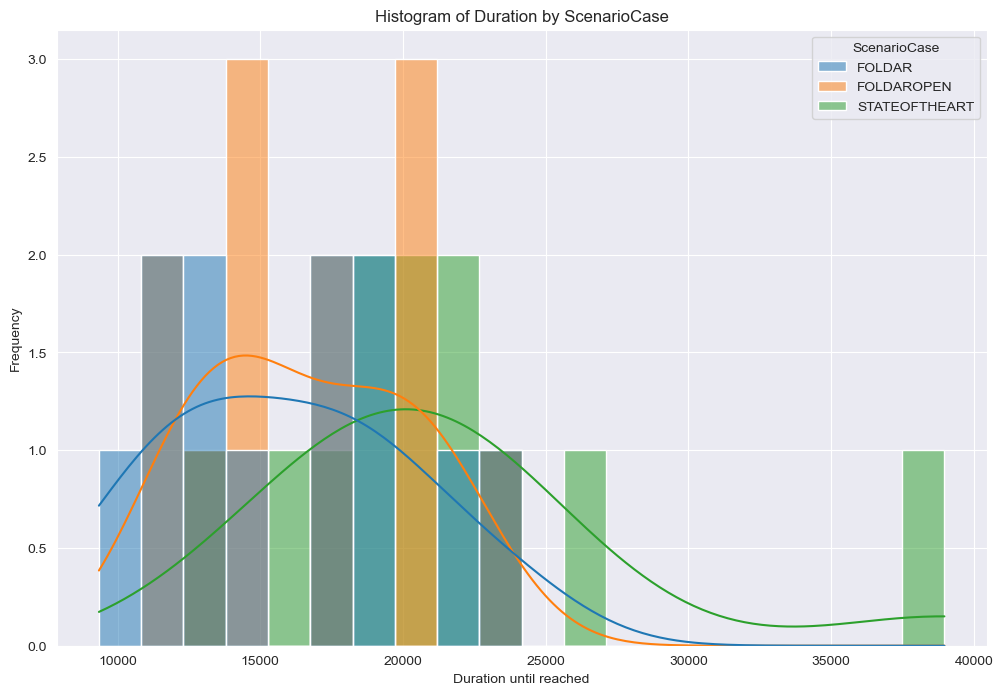

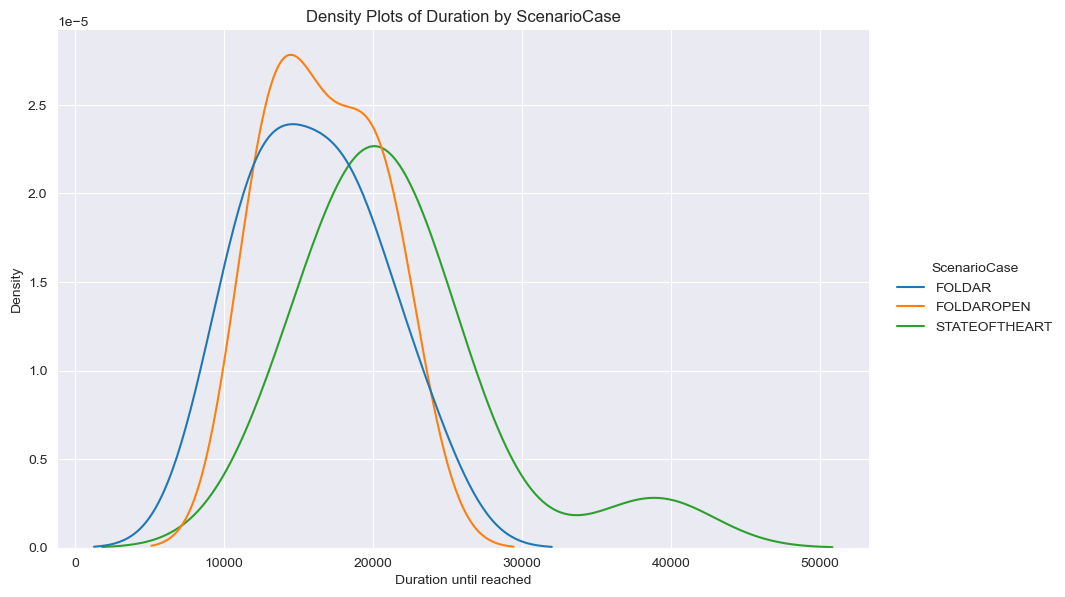

In [69]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["DurationReached"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(summary_stats)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Duration by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Duration by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

In general it takes longer to reach the target with STATEOFTHEART

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.977056 | p-value: 0.969129
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.940858 | p-value: 0.509263
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.846014 | p-value: 0.032791


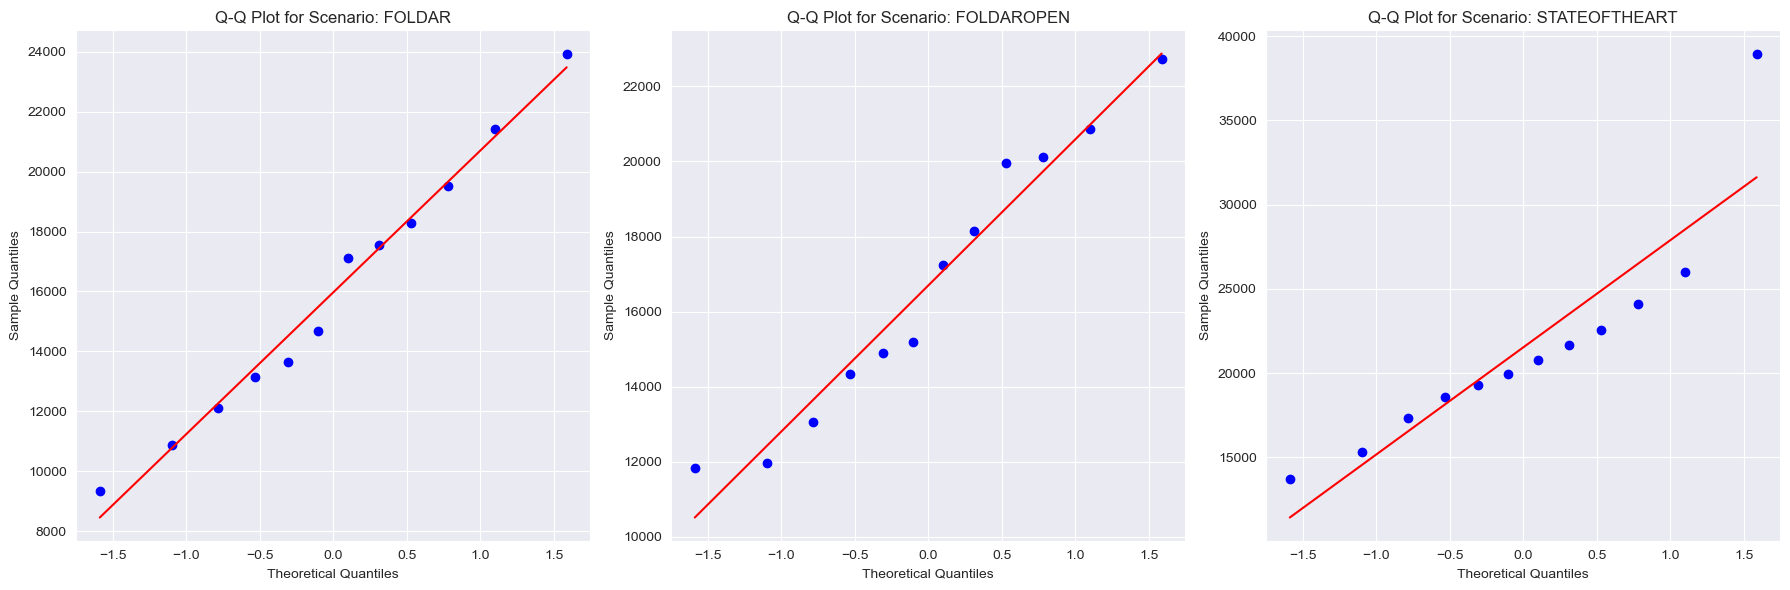

In [70]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()



# Friedman Test

Friedman Test Statistic: 8.166666666666657
p-value: 0.016851201259947587
Significant differences exist between the groups (ScenarioCase).


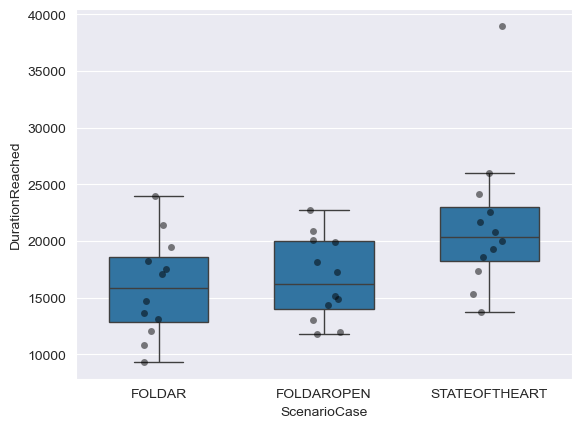

In [71]:
scenario_data = [DataCombinedAvgAggregated[DataCombinedAvgAggregated['ScenarioCase'] == case][tested_variable].values
                 for case in DataCombinedAvgAggregated['ScenarioCase'].unique()]

stat, p_value = friedmanchisquare(*scenario_data)

print(f"Friedman Test Statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant differences exist between the groups (ScenarioCase).")
else:
    print("No significant differences found.")

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()

There's an effect on Scenario by duration until the target is reached.


# Post-Hoc-Testing

# Wilcoxon Test

In [72]:
pairwise_results = pg.pairwise_tests(dv=tested_variable,
                                     within='ScenarioCase',
                                     subject=observed_group,
                                     data=DataCombinedAvgAggregated,
                                     padjust='holm',
                                     parametric=False)

print("\nPairwise Comparisons Table:")
print(tabulate(pairwise_results, headers='keys', tablefmt='psql', showindex=False))


Pairwise Comparisons Table:
+--------------+------------+---------------+----------+--------------+---------+---------------+------------+-----------+------------+-----------+
| Contrast     | A          | B             | Paired   | Parametric   |   W-val | alternative   |      p-unc |    p-corr | p-adjust   |    hedges |
|--------------+------------+---------------+----------+--------------+---------+---------------+------------+-----------+------------+-----------|
| ScenarioCase | FOLDAR     | FOLDAROPEN    | True     | False        |      36 | two-sided     | 0.850098   | 0.850098  | holm       | -0.173497 |
| ScenarioCase | FOLDAR     | STATEOFTHEART | True     | False        |       6 | two-sided     | 0.00683594 | 0.0205078 | holm       | -0.966021 |
| ScenarioCase | FOLDAROPEN | STATEOFTHEART | True     | False        |      10 | two-sided     | 0.0209961  | 0.0419922 | holm       | -0.883173 |
+--------------+------------+---------------+----------+--------------+---------+--

# Analyzing Efficiency of Scenario by comparing to Clicks

In [73]:
queryDataTimeClicks = """SELECT
DurationClickPerfomance.*,
Position
FROM DurationClickPerfomance
RIGHT JOIN TestCaseData
ON TestCaseData.TestCaseID = DurationClickPerfomance.TestCaseID"""

Data = pd.read_sql_query(queryDataTimeClicks, conn)

DataAverage = Data.groupby([observed_group,'ScenarioCase'])[['DurationReachedSeconds', 'ClicksRough']].mean().reset_index().rename(columns={'DurationReachedSeconds': 'DurationReachedAvg'})

# Pareto Front Analysis

In [74]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract objectives from DataAverage.
objectives = DataAverage[['DurationReachedAvg', 'ClicksRough']].values

# Initialize the non-dominated sorting object.
nds = NonDominatedSorting()

# Get the list of fronts. With only_non_dominated_front=False,
# nds.do returns a list where each element contains the indices of solutions in that front.
fronts = nds.do(objectives, only_non_dominated_front=False)

# Create an empty array to hold the rank for each solution.
ranks = np.empty(len(objectives), dtype=int)

# Iterate over the fronts and assign the rank (front index) for each solution.
for rank, front in enumerate(fronts):
    for idx in front:
        ranks[idx] = rank

# Add the computed Pareto rank into your DataAverage DataFrame.
DataAverage['ParetoRank'] = ranks

ScenarioCase  FOLDAR  FOLDAROPEN  STATEOFTHEART
UserID                                         
2                  8           6             10
3                  4           9              9
4                  5           9             12
5                  0           1              7
6                  7           3              4
8                  0           5              5
10                 4           2              7
11                 3           5             10
12                 5           2              9
13                 8           3             11
14                 1           5              6
15                 2           4              8


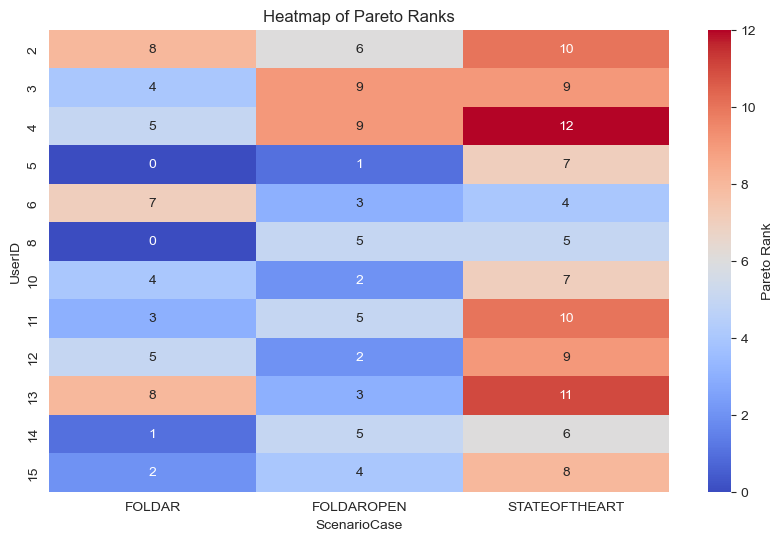

In [75]:
# Create a pivot table for ParetoRank
pivot_data = DataAverage.pivot(index=observed_group, columns='ScenarioCase', values='ParetoRank')
print(pivot_data)

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".0f", cbar_kws={'label': 'Pareto Rank'})
plt.title("Heatmap of Pareto Ranks")
plt.ylabel(observed_group)
plt.xlabel("ScenarioCase")
plt.show()

| ScenarioCase   | DurationReachedAvg | ClicksRough | ParetoRank |
| -------------- | ------------------ | ----------- | ---------- |
| FOLDAR         | 15.966142          | 237.108333  | 0          |
| FOLDAROPEN     | 16.696746          | 258.395833  | 1          |
| STATEOFTHEART  | 21.531912          | 365.045833  | 2          |
